# Прогнозирование оттока клиентов банка
**Проект №6 Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Данные о поведении клиентов и данные расторжении договоров с банком.

**Цель проекта:**

Построить модель с предельно большим значением F1-меры (не менее 0.59), способную предсказать отток клиентов.

### Структура проекта
* [1. Загрузка и изучение общей информации датасета](#start)
* [2. Подготовка данных и исследование данных](#prepatation)
* [3. Обучение модели](#fitting)
    * [3.1 Обучение модели без учёта дисбаланса классов](#imbalanced)
    * [3.2 Обучение модели, учитывая дисбаланс классов](#balanced)
* [4. Тестирование модели](#testing)
* [5. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Загрузка и изучение общей информации датасета

#### Импортируем необходимые библиотеки

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#### Загружаем данные

In [2]:
dataset_name = 'Churn.csv'

try:
    data = pd.read_csv(f'../datasets/{dataset_name}', sep=',')
    print(f'Прочитан файл с данными: "./datasets/{dataset_name}"')
except:
    try:
        data = pd.read_csv(f'/datasets/{dataset_name}', sep=',') # yandex.praktikum
        print(f'Прочитан файл с данными: "/datasets/{dataset_name}"')
    except Exception as err:
        print(repr(err))

FileNotFoundError(2, 'No such file or directory')


In [3]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Описание данных

**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* Exited — факт ухода клиента

### Вывод
* датасет на 10000 строк с данными
* имеются пропуски по признаку Tenure
* признаки Geography, Gender являются категориальными

<a id="prepatation"></a>
## 2. Подготовка и исследование данных

Признак RowNumber дублирует индекс, поэтому удалим его

In [5]:
data = data.drop(['RowNumber'], axis=1)

Избавимся от признаков CustomerId и Surname и будем использовать обезличенные данные

In [6]:
non_informative_features = ['CustomerId','Surname']

In [7]:
data = data.drop(non_informative_features, axis=1)

In [8]:
data['Tenure'].value_counts().sort_values()

0.0     382
10.0    446
6.0     881
9.0     882
4.0     885
7.0     925
5.0     927
3.0     928
8.0     933
2.0     950
1.0     952
Name: Tenure, dtype: int64

In [9]:
data.loc[data['Tenure'].isna(), 'Exited'].value_counts()

0    726
1    183
Name: Exited, dtype: int64

Заполним пропуски значениями от 1 до 10, чтобы не так сильно испортить распределение

In [11]:
data.loc[data['Tenure'].isna(), 'Tenure'] = data.loc[data['Tenure'].isna(), 'Tenure'].apply(lambda x: randrange(11))

Преобразуем категориальные признак Geography в числовой техникой Ordinal Encoding

In [12]:
data['Geography'].value_counts().sort_values()

Spain      2477
Germany    2509
France     5014
Name: Geography, dtype: int64

In [13]:
encoder = OrdinalEncoder()
new_clmn = encoder.fit_transform(data[['Geography']])
data = data.join(pd.Series(encoder.fit_transform(data[['Geography']])[:,0], name='Country')).drop('Geography', axis=1)

In [14]:
data['Gender'].value_counts().sort_values()

Female    4543
Male      5457
Name: Gender, dtype: int64

In [15]:
data = data.join(pd.get_dummies(data['Gender'], drop_first=True)).drop('Gender', axis=1)

Рассмотрим распределение числовых признаков

In [16]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.003900,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.746300,0.545700
std,96.653299,10.487806,2.919167,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.827529,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,8.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,2.000000,1.000000


Рассмотрим корреляцию признаков

In [17]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,Male
CreditScore,1.000000,-0.003965,0.006595,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.007888,-0.002857
Age,-0.003965,1.000000,-0.013318,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.022812,-0.027544
Tenure,0.006595,-0.013318,1.000000,-0.007370,0.009914,0.028446,-0.031264,0.007922,-0.014200,0.000575,0.009820
Balance,0.006268,0.028308,-0.007370,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.069408,0.012087
NumOfProducts,0.012238,-0.030680,0.009914,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.003972,-0.021859
HasCrCard,-0.005458,-0.011721,0.028446,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,-0.008523,0.005766
IsActiveMember,0.025651,0.085472,-0.031264,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.006724,0.022544
EstimatedSalary,-0.001384,-0.007201,0.007922,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.001369,-0.008112
Exited,-0.027094,0.285323,-0.014200,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.035943,-0.106512
Country,0.007888,0.022812,0.000575,0.069408,0.003972,-0.008523,0.006724,-0.001369,0.035943,1.000000,0.004719


### Вывод
* удалили признаки RowNumber, CustomerId, Surname, Tenure
* преобразовали признаки Geography, Gender в категориальные
* признак Age имеет наибольшую корреляция с целевым признаком

<a id="fitting"></a>
## 4. Обучение модели

Разделим датасет на обучающую, валидационную и тестовую выборку в пропорции 3:1:1

In [18]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']

features_train, X, target_train, y = train_test_split(features, target, test_size=0.4, stratify=target, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

In [19]:
print('Размер обучающей выборки:',features_train.shape[0])
print('Размер валидационной выборки:',features_valid.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])
print('Общий размер исходного датасета: {} (сумма выборок: {})'.
      format(data.shape[0], features_train.shape[0]+features_valid.shape[0]+features_test.shape[0]))

Размер обучающей выборки: 6000
Размер валидационной выборки: 2000
Размер тестовой выборки: 2000
Общий размер исходного датасета: 10000 (сумма выборок: 10000)


<a id="imbalanced"></a>
### 4.1 Обучение модели без учёта дисбаланса классов

Используем логистическую регрессию

In [20]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(StandardScaler(), LogisticRegression(random_state=91))
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.8075
Recall: 0.16666666666666666
F1 score: 0.26103646833013433
AUC_ROC: 0.7773148832397281


Используем случайный лес

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=91))
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.86
Recall: 0.47794117647058826
F1 score: 0.5820895522388059
AUC_ROC: 0.8623355749334908


Посмтроим график кривой ошибок

In [22]:
# Plot ROC curve
def plot_roc_curve(fpr=None, tpr=None, model_name=None):
    """Plot custom histogram"""
    plt.figure(figsize=(8,6))
    plt.title('ROC-curve of '+model_name, fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    
    plt.plot(fpr, tpr)

    # ROC-curve of random model
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.grid(True)
    
    plt.show()

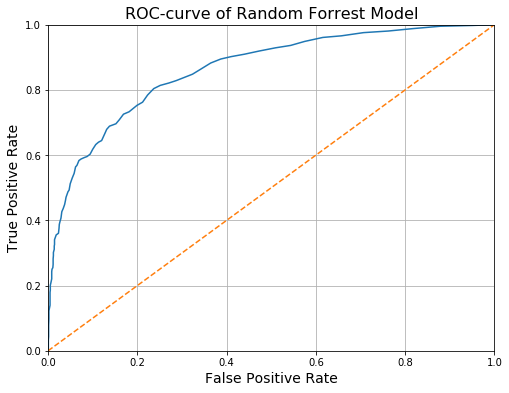

In [23]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plot_roc_curve(fpr, tpr, 'Random Forrest Model')

Исследуем баланс классов целевого признака

In [24]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Вывод
* Выявили дисбаланс классов целевого признака как 4:1. С помощью модели логической регрессии и случайного леса получили значения accuracy 0.81 и 0.86, F1-меры 0.26 и 0.59 соответственно. Если наша модель предсказывала бы только "0", то accuracy было бы около 0.8. Для того, чтобы модель пресказывала оба класса точнее учтём дисбаланс классов. Проверим насколько мы улучшим этот результат при учёте дисбаланса классов.

<a id="balanced"></a>
### 4.2 Обучение модели, учитывая дисбаланс классов

Применим технику upsampling (размножение выборки с меньшим классом) 

In [25]:
def upsample(features, target, value, repeat):
    features_down = features[target != value]
    features_up = features[target == value]
    target_down = target[target != value]
    target_up = target[target == value]

    features_upsampled = pd.concat([features_down] + [features_up] * repeat)
    target_upsampled = pd.concat([target_down] + [target_up] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=91)
    
    return features_upsampled, target_upsampled

Размножим строки с целевым признаком равным "1" в 2 раза

In [26]:
target_train.value_counts()

0    4778
1    1222
Name: Exited, dtype: int64

In [27]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 1, 2)

In [28]:
target_upsampled.value_counts()

0    4778
1    2444
Name: Exited, dtype: int64

Теперь у нас баланс классов в пропорции 2:1

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=91))
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.8485
Recall: 0.5367647058823529
F1 score: 0.5910931174089069
AUC_ROC: 0.8590416851413932


Добились небольшого увеличения F1-меры

In [30]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(StandardScaler(), LogisticRegression(random_state=91))
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.8075
Recall: 0.47794117647058826
F1 score: 0.5032258064516129
AUC_ROC: 0.7802431274017145


Применим технику downsampling (уменьшение выборки с большим классом) 

In [31]:
def downsample(features, target, value, fraction):
    features_down = features[target == value]
    features_up = features[target != value]
    target_down = target[target == value]
    target_up = target[target != value]

    features_downsampled = pd.concat(
        [features_down.sample(frac=fraction, random_state=91)] + [features_up])
    target_downsampled = pd.concat(
        [target_down.sample(frac=fraction, random_state=91)] + [target_up])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=91)
    
    return features_downsampled, target_downsampled

In [32]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0, 0.25)

In [33]:
target_downsampled.value_counts()

1    1222
0    1194
Name: Exited, dtype: int64

In [34]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=91))
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.7645
Recall: 0.803921568627451
F1 score: 0.5820763087843834
AUC_ROC: 0.8609946176963247


Применив технику downsampling F1-мера уменьшилась до 0.57 и при этом уменьшилось accuracy до 0.81, так как мы избавились от части данных с целевым признаком равным "0".

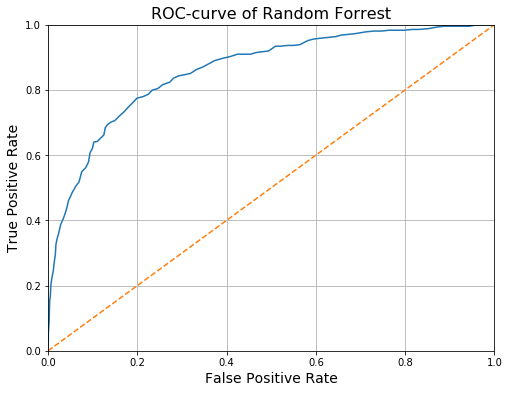

In [35]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plot_roc_curve(fpr, tpr, 'Random Forrest')

Попробуем применить upsampling и undersampling используя алгоритм SMOTE, подбирая наилучшие параметры в цикле

In [36]:
!pip install imbalanced-learn==0.7.0
print()

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

f1_best = 0
auc_roc_best = 0
features_resampled = None
target_resampled = None

for up, down in itertools.product((0.3, 0.35, 0.4, 0.45, 0.5, 0.9), (0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.9, 1.0)):
    if(down < up):
        continue

    over = SMOTE(sampling_strategy=up, random_state=91)
    under = RandomUnderSampler(sampling_strategy=down, random_state=91)

    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    features_, target_ = pipeline.fit_resample(features_train, target_train.ravel())

    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, random_state=91))
    model.fit(features_, target_)

    predicted_valid = model.predict(features_valid)

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > f1_best and auc_roc > auc_roc_best: # check if F1 and AUC-ROC are best
        f1_best = f1
        auc_roc_best = auc_roc
        features_resampled = features_
        target_resampled = target_
        print(f'F1-score={f1_best} if upsampling={up} and downsampling={down}')

model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=91))
model.fit(features_resampled, target_resampled)
        
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
             
accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print()
print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC-ROC:', auc_roc)


F1-score=0.6090425531914894 if upsampling=0.3 and downsampling=0.4
F1-score=0.6101295641931683 if upsampling=0.45 and downsampling=0.7

Accuracy: 0.8345
Recall: 0.6348039215686274
F1 score: 0.6101295641931683
AUC-ROC: 0.8676740011331165


**Получили значение F1-меры 0.62 при коэффициентах upsampling=0.3 and downsampling=0.7**

Используем обработанный датасет и подберём параметры для Random Forrest

In [37]:
# Criterions to iterate
min_depth = 6
max_depth = 12
max_leaf = 8
criterions = ('gini', 'entropy')
class_weights = (None, 'balanced')

best_model = None
best_result = 0
for n_estimators, depth, criterion, min_leaf, class_weight in list(itertools.product((50,100,150,200), range(min_depth,max_depth+1), criterions, np.arange(2,max_leaf+1,2), class_weights)):
    model = make_pipeline(StandardScaler(),
                          RandomForestClassifier(n_estimators=n_estimators,
                                                max_depth=depth,
                                                criterion=criterion,
                                                min_samples_leaf=min_leaf,
                                                class_weight=class_weight,
                                                n_jobs=-1,
                                                random_state=91))
    model.fit(features_resampled, target_resampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model

In [37]:
best_model.fit(features_resampled, target_resampled)

predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
             
accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1-score:', f1)
print('AUC-ROC:', auc_roc)
print(best_model)

Accuracy: 0.853
Recall: 0.6568627450980392
F1-score: 0.6457831325301204
AUC-ROC: 0.8728492339146715
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=8,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=91))])


Попробуем выполнить отбор признаков (Selection), по очереди удалим один из признаков и посмотрим как влияет это на значение F1-score

In [38]:
for clmn in data.columns:
    columns = list(set(data.columns) - set([clmn, 'Exited']))
    
    best_model.fit(features_resampled[columns], target_resampled)

    predicted_valid = best_model.predict(features_valid[columns])

    probabilities_valid = best_model.predict_proba(features_valid[columns])
    probabilities_one_valid = probabilities_valid[:, 1]

    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

    print(f'Without {clmn:<10}\t F1-score: {f1}\t AUC-ROC {auc_roc}')

Without CreditScore	 F1-score: 0.6066252587991718	 AUC-ROC 0.8666170928170264
Without Age       	 F1-score: 0.5297619047619048	 AUC-ROC 0.8018577877130751
Without Tenure    	 F1-score: 0.616649537512847	 AUC-ROC 0.8687139742831806
Without Balance   	 F1-score: 0.6077003121748179	 AUC-ROC 0.8585821263178638
Without NumOfProducts	 F1-score: 0.5599194360523666	 AUC-ROC 0.818250258646172
Without HasCrCard 	 F1-score: 0.6035379812695109	 AUC-ROC 0.8670820401024733
Without IsActiveMember	 F1-score: 0.5830188679245283	 AUC-ROC 0.8565976327717018
Without EstimatedSalary	 F1-score: 0.6100307062436028	 AUC-ROC 0.8664708345649818
Without Exited    	 F1-score: 0.6079664570230607	 AUC-ROC 0.8635964750221696
Without Country   	 F1-score: 0.5838150289017341	 AUC-ROC 0.8540827606168095
Without Male      	 F1-score: 0.6070686070686071	 AUC-ROC 0.8664515900581338


<s>Признак Male на валидационных данных ухудшает качество модели

### Вывод
* Применив методы upsampling и downsampling к данным, и, подобрав коэффициенты к этим методом, смогли достичь значения F1-меры до 0.65 на валидационных данных. При этом повысили значение метрики AUC-ROC до 0.87.
* <s>удаление признака Male незначительно улучшает F1-score на валидационных данных (видимо зависит от тошо какие данные удалены были при downsampling)

<a id="testing"></a>
## 5. Тестирование модели

In [39]:
best_model.fit(features_resampled, target_resampled)

predicted_test = best_model.predict(features_test)

probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
             
accuracy = accuracy_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
#auc_roc = roc_auc_score(target_test, predicted_test)

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.811
Recall: 0.7027027027027027
F1 score: 0.6021052631578947
AUC_ROC: 0.8567149584098737


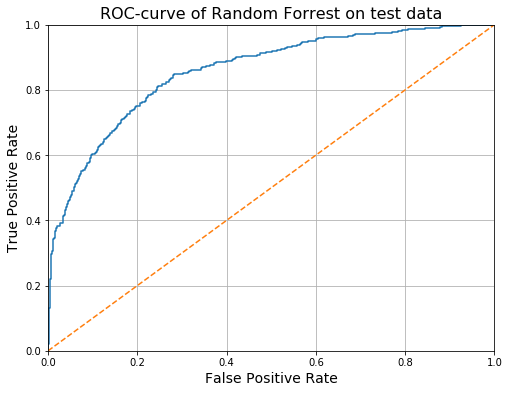

In [40]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plot_roc_curve(fpr, tpr, 'Random Forrest on test data')

<a id="conclusion"></a>
## 6. Общий вывод

### Вывод
* Использовали модель Random Forrest. Применив методы upsampling и downsampling к данным, и, подобрав параметры модели смогли получить значение F1-меры выше 0.59.